<a id='contents'></a>

<a id='running'></a>

<a id='setup_computer'></a>

In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 28.4 MB/s eta 0:00:0000:0100:01


<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [3]:
import uproot3 # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks

import infofile # local file containing cross-sections, sums of weights, dataset IDs

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of luminosity, fraction of data used, where to access the input files

In [4]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.09 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address


<a id='samples'></a>

## Samples

samples to process

In [34]:
samples = {

    'data': {
        'list' : ['data_A','data_B']
    },
    
    r'$Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },
    
    r'$t\bar{t}V$' : { # ttV
        'list' : ['ttW','ttee','ttmumu'], # ttW, ttZ(->ee), ttZ(->mm)
        'color' : "#f0f423" # yellow
    },
    
    'ZZ' : { # ZZ->llll
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    'Graviton' : {
        'list' : ['RS_G_ZZ_llll_c10_m0500'], # mG = 500 GeV
        'color' : "#baff8d" # green
    },

}

Define function to get data from files

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [35]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

define function to calculate weight of MC event

In [36]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [37]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass

In [38]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [39]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [40]:
def read_file(path, sample):
  start = time.time()  # start the clock
  print("\tProcessing: "+sample)  # print which sample is being processed
  data_all = pd.DataFrame()  # define empty pandas DataFrame to hold all data for this sample
  tree = uproot3.open(path)["mini"]  # open the tree called mini
  numevents = uproot3.numentries(path, "mini")  # number of events
  if 'data' not in sample: xsec_weight = get_xsec_weight(sample)  # get cross-section weight
  for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                          'lep_E','lep_charge','lep_type',  
                          # add more variables here if you make cuts on them  
                          'mcWeight','scaleFactor_PILEUP',
                          'scaleFactor_ELE','scaleFactor_MUON',
                          'scaleFactor_LepTRIGGER'],  # variables to calculate Monte Carlo weight
                          outputtype=pd.DataFrame,  # choose output type as pandas DataFrame
                          entrystop=numevents*fraction):  # process up to numevents*fraction

    nIn = len(data.index)  # number of events in this batch

    if 'data' not in sample:  # only do this for Monte Carlo simulation files
      # multiply all Monte Carlo weights and scale factors together to give total weight
      data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                        data.mcWeight,
                                                        data.scaleFactor_PILEUP,
                                                        data.scaleFactor_ELE,
                                                        data.scaleFactor_MUON,
                                                        data.scaleFactor_LepTRIGGER)

      # cut on lepton charge using the function cut_lep_charge defined above
      fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
      data.drop(fail, inplace=True)

      # cut on lepton type using the function cut_lep_type defined above
      fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
      data.drop(fail, inplace=True)

      # calculation of 4-lepton invariant mass using the function calc_mllll defined above

    data['mllll'] = data.apply(lambda row: calc_mllll(row['lep_pt'], row['lep_eta'], row['lep_phi'], row['lep_E']), axis=1)
    
      # dataframe contents can be printed at any stage like this
      #print(data)

      # dataframe column can be printed at any stage like this
      #print(data['lep_pt'])

      # multiple dataframe columns can be printed at any stage like this
      #print(data[['lep_pt','lep_eta']])

    nOut = len(data.index)  # number of events passing cuts in this batch

    # Append dataframe using concat instead of append
    data_all = pd.concat([data_all, data], ignore_index=True)

    elapsed = time.time() - start  # time taken to process
    print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s")  # events before and after

  return data_all  # return dataframe containing events passing all cuts


This is where the processing happens (this will take some minutes)

In [41]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 3,	 nOut: 	3	 in 0.5s
	Processing: data_B
		 nIn: 14,	 nOut: 	14	 in 0.5s
Processing $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 80,	 nOut: 	17	 in 1.4s
	Processing: Zmumu
		 nIn: 61,	 nOut: 	26	 in 1.2s
	Processing: ttbar_lep
		 nIn: 92,	 nOut: 	28	 in 1.8s
Processing $t\bar{t}V$ samples
	Processing: ttW
		 nIn: 123,	 nOut: 	27	 in 3.1s
	Processing: ttee
		 nIn: 2888,	 nOut: 	1285	 in 55.5s
	Processing: ttmumu
		 nIn: 2397,	 nOut: 	983	 in 38.6s
Processing ZZ samples
	Processing: llll
		 nIn: 49885,	 nOut: 	47162	 in 39.6s
Processing Graviton samples
	Processing: RS_G_ZZ_llll_c10_m0500
		 nIn: 584,	 nOut: 	538	 in 22.2s
Time taken: 164.5s


<a id='plotting'></a>

## Plotting
If you only want a make a change in plotting: Cell -> Run All Below

Define class to display log values

In [42]:
# define class to display 1 and 10 normally
class CustomTicker(LogFormatterSciNotation): 
    def __call__(self, x, pos=None): 
        if x not in [1,10]: # not 1 or 10
            return LogFormatterSciNotation.__call__(self,x, pos=None)
        else: # 1 or 10
            return "{x:g}".format(x=x) # standard notation

Define function to plot the data

In [43]:
def plot_data(data):

    xmin = 130 # GeV
    xmax = 1230 # GeV
    step_size = 55 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
    
    data_x, _ = np.histogram(data['data']['mllll'], bins=bin_edges) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data['Graviton']['mllll'] # histogram the signal
    signal_weights = data['Graviton'].totalWeight # get the weights of the signal events
    signal_color = samples['Graviton']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', 'Graviton']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label='Graviton')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    main_axes.set_yscale('log') # set y-scale
    smallest_contribution = mc_heights[0][0] # get smallest contribution
    smallest_contribution.sort() # sort smallest contribution
    bottom = np.amax(data_x)/1000 # set bottom limit on y-axis
    top = np.amax(data_x)*100 # set top limit on y-axis
    main_axes.set_ylim( bottom=bottom, top=top ) # y-axis limits
    main_axes.yaxis.set_major_formatter( CustomTicker() ) 
    locmin = LogLocator(base=10.0, # log base 10
                        subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) ) # minor tick every 0.1 
    main_axes.yaxis.set_minor_locator( locmin ) # set minor ticks

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(round(lumi*fraction,2)) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.75, # y
             r'$G \rightarrow ZZ \rightarrow l^+l^-l^+l^-$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(ncol=2, # 2 columns
                     frameon=False ) # no box around the legend
    
    return

Call the function to plot the data

In [44]:
print(data['data'])

                                          lep_pt  \
0     [49138.344, 43451.65, 43018.27, 27352.213]   
1    [175558.73, 138846.67, 106696.53, 79776.73]   
2    [65284.066, 37290.766, 12426.926, 8804.564]   
0      [49045.12, 38049.31, 35706.69, 34415.664]   
1       [28315.65, 27379.48, 18381.793, 7977.39]   
2    [52658.766, 50908.273, 39159.105, 28929.13]   
3   [188332.34, 136203.61, 56817.598, 11388.731]   
4       [73055.63, 36003.42, 34772.84, 28750.44]   
5    [45560.914, 42681.53, 20502.748, 11710.931]   
6    [65421.633, 35774.56, 15092.131, 11639.622]   
7      [63783.8, 40107.074, 21195.172, 10364.31]   
8      [28958.545, 28543.45, 8355.206, 7019.401]   
9    [99818.43, 28418.986, 10979.692, 10289.164]   
10     [35399.582, 31610.88, 9356.227, 7311.662]   
11   [47615.34, 39254.035, 20912.867, 16226.882]   
12   [80432.46, 42100.566, 28484.209, 14414.887]   
13    [50715.46, 33097.516, 12241.644, 8078.165]   

                                              lep_eta  \
0   [-

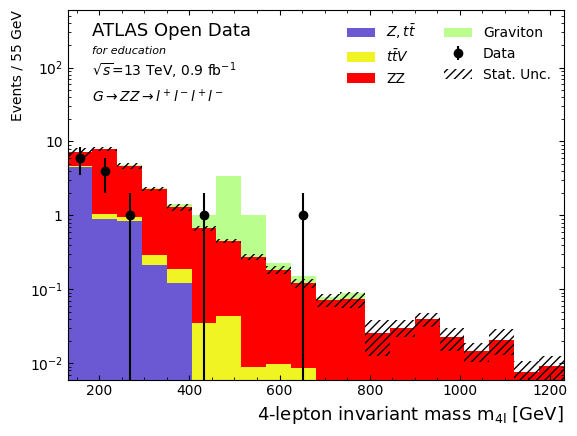

In [45]:
plot_data(data)

<a id='going_further'></a>